In [1]:
!nvidia-smi

Sun Jun 23 13:55:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# this notebook environment is reliant on the host device's GPU and its other benchmark settings

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T135233Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D465706738bde7fa78ef5ac41475d23ab4fac84aad09b2efe049ce5bb58295c2885b9a076c28159155efff659132d2cd5a9e552fb21c50f03b17252107d120417c59ab212b68b1e64ace4f41a02a0780b087ec992d7ebb2eef3954d6fed7a5c7291e08b1ebe4e07424692ca332826bdb203c48340ad79dfd93fa75db28cd61905e56ae09891db7cd465cdbd8754d8f90c201fe9a2f677818e0d5a89a6adcc4104f07885eb034cd0b7707cf773e6e63d1696a6471233f73582dc6ff39882903264e8bcc9b67085584fb832ca1350c0ee938d03e94f7f8a61236b0b97013e3f77722bc1a1f08f7ba0af53fdb296d0fec16b724497cd5768b587f289a2fdb13a2445'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


<p>This work implements the VGG16 Convolutional Neural Networks and a type of Recurrent Neural Network(LSTM) together.</p>

The objective of this work is to learn the concepts of the VGG16 CNN and LSTM models by building a model which implements both methodologies to generate NL based prompts with given image data inputs.

The image features are extracted from Xception which is another CNN model trained on the ImageNet dataset, then fed into the LSTM model which will be responsible for generating the prompts.

# Dataset

This work implements the Flickr_8K dataset. There are also other big datasets like Flickr_30K or MSCOCO but it would take days just to train the NN model, which is considered inefficient in this work instance. The advantage of bigger datasets is that better models will be produced, with the expense of time.

The Flickr_8K dataset is available as follows :
<a href="https://www.kaggle.com/datasets/adityajn105/flickr8k">Kaggle-Flicker8k</a> (Size: 1GB).

# Modules

In [3]:
import os                                                                          # handling the files
import pickle                                                                      # storing numpy features
import numpy as np
from tqdm.notebook import tqdm                                                     # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input           # extract features from image data
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

**os** - used to handle files using system commands.

**pickle** - used to store numpy features extracted

**numpy** - used to perform a wide variety of mathematical operations on arrays

**tqdm** - progress bar decorator for iterators. Includes a default range iterator printing to stderr.

**VGG16, preprocess_input** - imported modules for feature extraction from the image data

**load_img, img_to_array** - used for loading the image and converting the image to a numpy array

**Tokenizer** - used for loading the text as convert them into a token

**pad_sequences** - used for equal distribution of words in sentences filling the remaining spaces with zeros

**plot_model** - used to visualize the architecture of the model through different images

#### SET data directories

In [4]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Load The VGG16 Model

VGG-16 is a 16 - layers deep CNN. You can load a pretrained version of this network trained on more than a million images from ImageNet db. The pretrained network can classify images into 1000 object categories, such as keyboards, mouses, pencils, animals and more, in accordance with the proper documentation.

In [5]:
# Load vgg16
model = VGG16()

# Network restructural
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

+ A fully connected layer of VGG16 is not needed, just the previous layers to extract feature results.

+ By preference you may include more layers, but for quicker results you should avoid adding unnecessary layers.

# Extract Image Features

features are stored in hashable obj for further pre - processing.

In [6]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):

    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224, 224))

    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data into (1, 224, 224, 3)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for vgg
    image = preprocess_input(image)

    # extract features
    feature = model.predict(image, verbose = 0)

    # get image ID
    image_id = img_name.split('.')[0]

    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

Hashable 'features' is created and will be loaded with the extracted features of image data

**load_img(img_path, target_size=(224, 224))** - custom dimension to resize the image when loaded to the array

**image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))** - reshaping the image data to pre - process into RGB type image.

**model.predict(image, verbose=0)** - extraction of features from the image

**img_name.split('.')[0]** - split of the image name from the extension to load only the image name.

In [7]:
# store features in temp placeholder pickle file
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Extracted features are not stored in the notebook's disk, so re - extraction of features can extend, in other words, consume more running time.

Dumps and store the hashtable in a pickle instance for quicker feature loading.

In [8]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load The NL Data

The text file inside Flickr_8K contains word tokens for each training data, which are then supplied to VGG16.

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Split and Append The NL Data with The Image

In [10]:
# create mapping of image to each appropriate word tokens.
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):

    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]

    # remove extension from image ID
    image_id = image_id.split('.')[0]

    # convert caption list to string
    caption = " ".join(caption)

    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

+ Hashable 'mapping' is created with key as image_id and values as the corresponding caption text.

+ One image may have multiple appropriate tokens, **if image_id not in mapping: mapping[image_id] = []** creates a list for appending captions to the corresponding image.

#### Number of Training Images Loaded

In [11]:
len(mapping)

8091

In [12]:
def clean(mapping):
    '''
    Caption token pre - processing
    '''
    for key, captions in mapping.items():
        for i in range(len(captions)):

            # take one word token at a time
            caption = captions[i]

            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()

            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')

            # delete additional spaces
            caption = caption.replace('\s+', ' ')

            # add start and end tags to the each word token
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

To clean and convert the text for quicker process and better results.

Below is a visualization of the text **before** and **after** cleaning.

In [13]:
# before pre - processing of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
# pre - process the text
clean(mapping)

In [15]:
# after
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Store Pre - Processed Tokens in A List

In [16]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
# Number of unique tokens stored
len(all_captions)

40455

### View The First Ten Tokens

In [18]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Processing of Text Data

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

8485

Number of unique words

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

+ The maximum length of the captions is meant as a reference for the padding sequence.

# Train - Test Split

In [22]:
image_ids = list(mapping.keys())

split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Define A Batch and Include The Padding Sequence**

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            # process each caption
            for caption in captions:

                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                for i in range(1, len(seq)):

                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence

                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence

                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Padding sequence normalizes the size of each token to the max size filling them with zeros for better results.

# Define Model Encoders

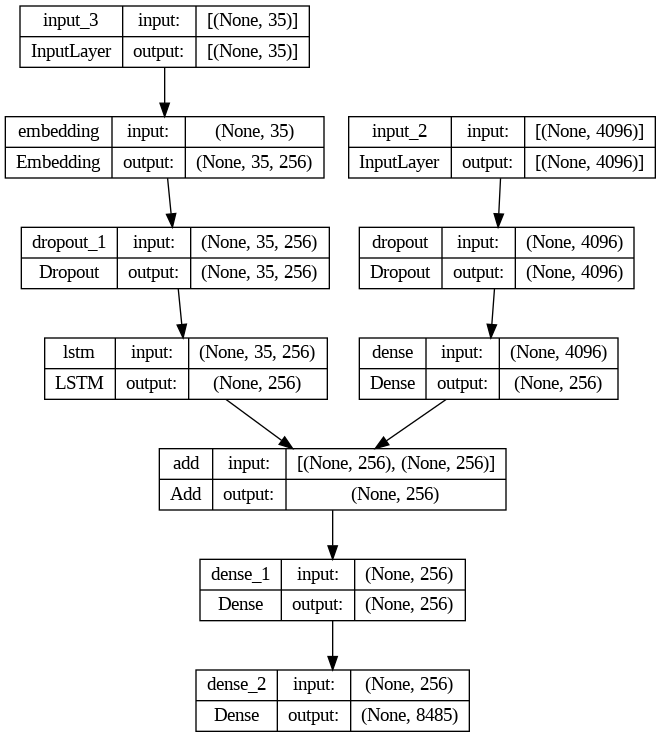

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# plot the model
plot_model(model, show_shapes = True)

+ **shape=(4096,)** - output length of the features from the VGG model

+ **Dense** - single dimension linear layer array

+ **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

+ **model.compile()** - compilation of the model

+ **loss=’sparse_categorical_crossentropy’** - loss function for category outputs

+ **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

+ Model plot shows the concatenation of the inputs and outputs into a single layer

+ Feature extraction of image was already done using VGG, no CNN model was needed in this step.

# Training The Encoder Architecture

In [25]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for each epoch iteration
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)

227/227 [==============================] - 55s 244ms/step - loss: 2.1917


+ **steps = len(train) // batch_size** - back propagation and fetch the next data

+ Loss rate will decrease gradually over the iterations

+ Increase number of epochs for better results

+ Assign number of epochs and batch size accordingly for quicker results


### Current Model is Saved in The Working Directory for Reuse.

In [39]:
# save current model
model.save(WORKING_DIR+'/saved_model.h5')
model.save('saved_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generating Text for Images

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

<p>Convert the predicted index from the model into a word.</p>

In [28]:
# generate text for an image
def predict_caption(model, image, tokenizer, max_length):

    # add start tag for generation process
    in_text = 'startseq'

    # iterate over the max length of sequence
    for i in range(max_length):

        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # pad the sequence
        sequence = pad_sequences([sequence], max_length)

        # predict next word
        yhat = model.predict([image, sequence], verbose = 0)

        # get index with high probability
        yhat = np.argmax(yhat)

        # convert index to word
        word = idx_to_word(yhat, tokenizer)

        # stop if word not found
        if word is None:
            break

        # append word as input for generating next word
        in_text += " " + word

        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

+ The function appends all words for each image.

+ Each produced prompt starts with **'startseq'** and the model continues to predict the caption until the **'endseq'** appeared.

# Model Validation
Score each prompt result using the BLEU metric.

In [29]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):

    # get actual prompt
    captions = mapping[key]

    # predict the prompt for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533319
BLEU-2: 0.312118


+ BLEU Score is used to evaluate the predicted prompt against a reference text, in a list of tokens.

+ The reference text contains all the words appended from the prompt data(actual_captions).

+ A BLEU Score more than **0.5 is considered a good result**, for a better score increase the number of epochs accordingly.

In [69]:
# pick random samples from the test batch
import random

def test_generator(n_samples = 1):
    start = 0
    sample_list = sorted(test, key = lambda x : random.random())
    for item in sample_list[start:n_samples]:
        print(item + ".jpg")

test_generator(n_samples = 10)

633456174_b768c1d6cd.jpg
909191414_1cf5d85821.jpg
489372715_ce52da796a.jpg
58363928_6f7074608c.jpg
458004873_f084c47a88.jpg
634891010_9fa189effb.jpg
979383193_0a542a059d.jpg
512634877_d7ad8c8329.jpg
486720042_b785e7f88c.jpg
862054277_34b5a6f401.jpg


## Results

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_prompt(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # predict the prompt
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy in red and girl pink are walking through low cut field endseq
startseq the little boy and little girl are walking side by side endseq
startseq two small children walk away in field endseq
startseq two small children walking in field endseq
startseq two young children are walking across an open field endseq
--------------------Predicted--------------------
startseq two children playing in field hockey endseq


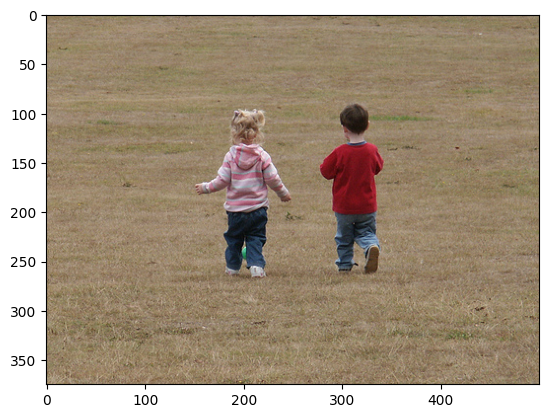

In [53]:
generate_prompt("438639005_208bc59b0b.jpg")

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the sidewalk endseq


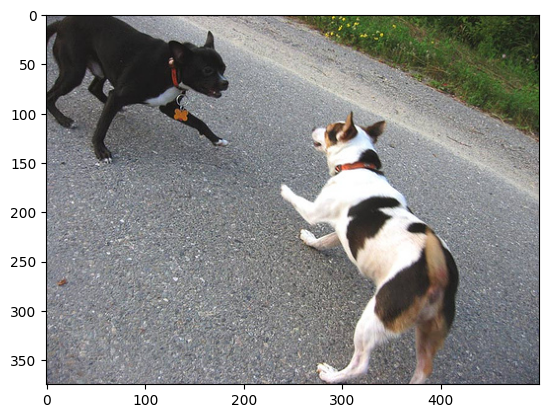

In [31]:
generate_prompt("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted--------------------
startseq little girl climbs an ice net endseq


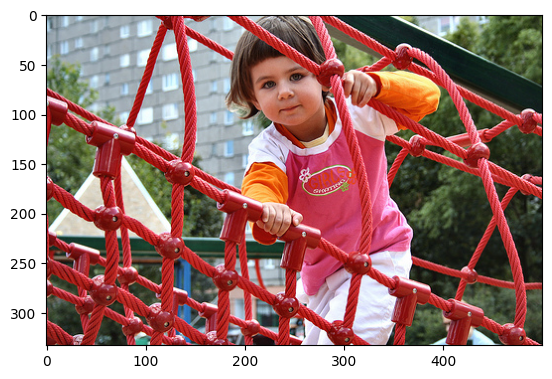

In [32]:
generate_prompt("1007320043_627395c3d8.jpg")

---------------------Actual---------------------
startseq boy in his blue swim shorts at the beach endseq
startseq boy smiles for the camera at beach endseq
startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq
startseq children playing on the beach endseq
startseq the boy is playing on the shore of an ocean endseq
--------------------Predicted--------------------
startseq little boy in blue shorts and shorts is walking on the beach endseq


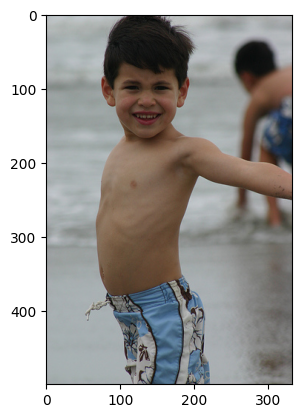

In [33]:
generate_prompt("106490881_5a2dd9b7bd.jpg")

---------------------Actual---------------------
startseq brown dog running down paved pathway endseq
startseq brown dog running next to grass endseq
startseq dog is running down road endseq
startseq light brown dog runs down path happily endseq
startseq energetic brown dog running endseq
--------------------Predicted--------------------
startseq brown dog is running down dirt path endseq


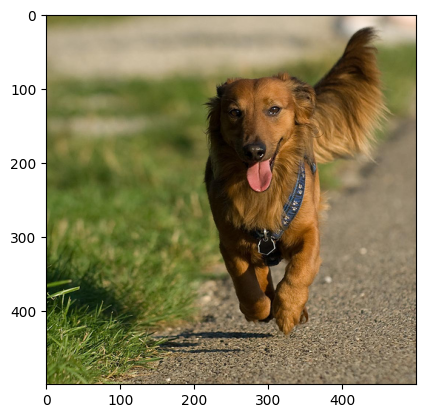

In [34]:
generate_prompt("1089181217_ee1167f7af.jpg")

---------------------Actual---------------------
startseq man climbing rock wall endseq
startseq man climbing the side of cliff endseq
startseq man is rock climbing endseq
startseq "man with red shoes white shirt and grey pants climbing ." endseq
startseq the young man with the white t-shirt and jeans is rappeling up the rock wall endseq
--------------------Predicted--------------------
startseq man wearing red shirt is rappeling up the rock wall endseq


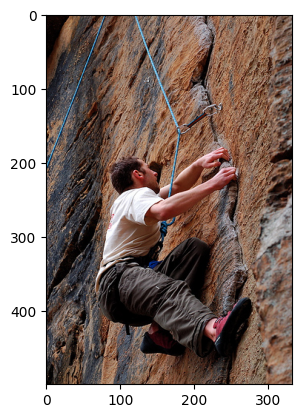

In [35]:
generate_prompt("111537217_082a4ba060.jpg")

# Final Thoughts

+ Training the model by increasing number of epochs can give better and more accurate results.

+ Processing larger amounts of data will definitely consume much more time and system resource.

+ The number of layers of the model can be increased if you want to process larger datasets, for instance the flickr32k version of the implemented dataset here.

## Load Models(Further Applicable Experiments)


In [41]:
from keras.models import load_model

imported_model = load_model('saved_model.h5')